# Import Libraries

In [10]:

import os
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from code.classifier import PneumoniaClassifier, Config
from code.plot_random_image import plot_random_image_from_loader
from code.classify_random_images import plot_random_images_with_labels
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt



In [11]:

# Load the TensorBoard
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

# Check GPU Availability

In [13]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Dec  2 20:28:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   45C    P8             13W /  285W |    3621MiB /  12282MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup Model

In [14]:
config = Config(
    backbone_name="resnet18",
    transfer_learning=True,
    learning_rate=1e-4,
    batch_size=20,
    max_epochs=50,
    weight_decay=1e-4,
    dropout=0.2,
    num_workers=16,
    model_name="ResNet18_equalized",
    version="001",
    optimizer_name = "sgd",
    use_class_weights=True,
    image_res=224,
    patience = 10,
    image_type=2
)
model = PneumoniaClassifier(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Plot random images from all datasets

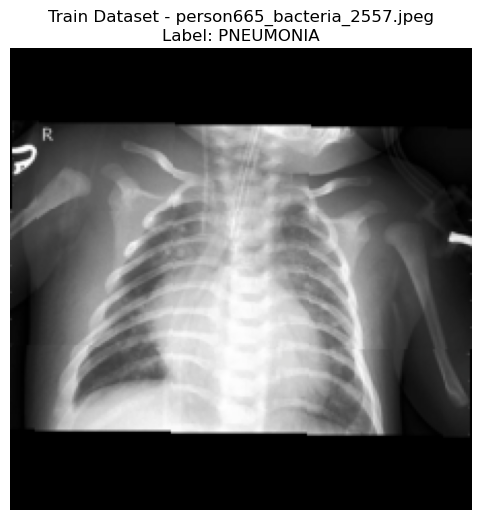

In [15]:
plot_random_image_from_loader(model.train_loader.dataset, "Train Dataset")

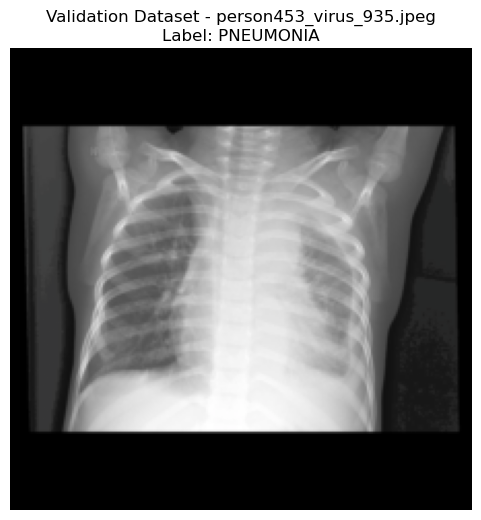

In [16]:
plot_random_image_from_loader(model.val_loader.dataset, "Validation Dataset")

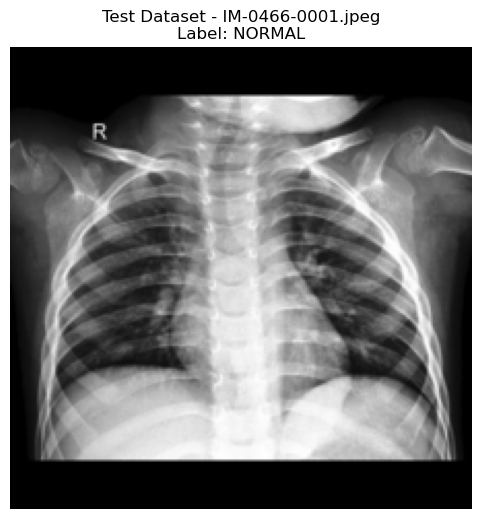

In [17]:
plot_random_image_from_loader(model.test_loader.dataset, "Test Dataset")

# Train Model

In [18]:

# Train Model
model.train_model()
torch.save({
    "state_dict": model.state_dict(),
    "config": config
}, f"../models/{config.model_name}_final.pt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | accuracy          | BinaryAccuracy    | 0      | train
1 | precision         | BinaryPrecision   | 0      | train
2 | recall            | BinaryRecall      | 0      | train
3 | f1                | BinaryF1Score     | 0      | train
4 | specificity       | BinarySpecificity | 0      | train
5 | feature_extractor | Sequential        | 11.2 M | train
6 | dropout           | Dropout           | 0      | train
7 | classifier        | Linear            | 1.0 K  | train
----------------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 205/205 [00:19<00:00, 10.35it/s, v_num=1, train_loss_step=0.296]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 205/205 [00:25<00:00,  8.19it/s, v_num=1, train_loss_step=0.296, val_acc_epoch=0.777, val_precision_epoch=0.901, val_recall_epoch=0.780, val_f1_epoch=0.836, val_specificity_epoch=0.768]

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 18. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.411


Epoch 1: 100%|██████████| 205/205 [00:18<00:00, 11.06it/s, v_num=1, train_loss_step=0.417, val_acc_epoch=0.777, val_precision_epoch=0.901, val_recall_epoch=0.780, val_f1_epoch=0.836, val_specificity_epoch=0.768]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 205/205 [00:23<00:00,  8.61it/s, v_num=1, train_loss_step=0.417, val_acc_epoch=0.862, val_precision_epoch=0.941, val_recall_epoch=0.865, val_f1_epoch=0.901, val_specificity_epoch=0.854]

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 0.312


Epoch 2: 100%|██████████| 205/205 [00:18<00:00, 11.15it/s, v_num=1, train_loss_step=0.296, val_acc_epoch=0.862, val_precision_epoch=0.941, val_recall_epoch=0.865, val_f1_epoch=0.901, val_specificity_epoch=0.854]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 205/205 [00:18<00:00, 10.97it/s, v_num=1, train_loss_step=0.329, val_acc_epoch=0.871, val_precision_epoch=0.952, val_recall_epoch=0.867, val_f1_epoch=0.908, val_specificity_epoch=0.882]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 205/205 [00:23<00:00,  8.66it/s, v_num=1, train_loss_step=0.329, val_acc_epoch=0.880, val_precision_epoch=0.952, val_recall_epoch=0.881, val_f1_epoch=0.915, val_specificity_epoch=0.879]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.291


Epoch 4: 100%|██████████| 205/205 [00:18<00:00, 11.01it/s, v_num=1, train_loss_step=0.365, val_acc_epoch=0.880, val_precision_epoch=0.952, val_recall_epoch=0.881, val_f1_epoch=0.915, val_specificity_epoch=0.879]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 205/205 [00:23<00:00,  8.63it/s, v_num=1, train_loss_step=0.365, val_acc_epoch=0.885, val_precision_epoch=0.952, val_recall_epoch=0.887, val_f1_epoch=0.919, val_specificity_epoch=0.880]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.252


Epoch 5: 100%|██████████| 205/205 [00:18<00:00, 11.19it/s, v_num=1, train_loss_step=0.236, val_acc_epoch=0.885, val_precision_epoch=0.952, val_recall_epoch=0.887, val_f1_epoch=0.919, val_specificity_epoch=0.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 205/205 [00:18<00:00, 11.08it/s, v_num=1, train_loss_step=0.179, val_acc_epoch=0.891, val_precision_epoch=0.957, val_recall_epoch=0.891, val_f1_epoch=0.923, val_specificity_epoch=0.891]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 205/205 [00:23<00:00,  8.69it/s, v_num=1, train_loss_step=0.179, val_acc_epoch=0.893, val_precision_epoch=0.957, val_recall_epoch=0.893, val_f1_epoch=0.924, val_specificity_epoch=0.892]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.251


Epoch 7: 100%|██████████| 205/205 [00:18<00:00, 10.91it/s, v_num=1, train_loss_step=0.213, val_acc_epoch=0.893, val_precision_epoch=0.957, val_recall_epoch=0.893, val_f1_epoch=0.924, val_specificity_epoch=0.892]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 205/205 [00:23<00:00,  8.60it/s, v_num=1, train_loss_step=0.213, val_acc_epoch=0.896, val_precision_epoch=0.959, val_recall_epoch=0.896, val_f1_epoch=0.926, val_specificity_epoch=0.897]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.246


Epoch 8: 100%|██████████| 205/205 [00:18<00:00, 10.91it/s, v_num=1, train_loss_step=0.363, val_acc_epoch=0.896, val_precision_epoch=0.959, val_recall_epoch=0.896, val_f1_epoch=0.926, val_specificity_epoch=0.897]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 205/205 [00:23<00:00,  8.58it/s, v_num=1, train_loss_step=0.363, val_acc_epoch=0.898, val_precision_epoch=0.960, val_recall_epoch=0.898, val_f1_epoch=0.928, val_specificity_epoch=0.900]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.243


Epoch 9: 100%|██████████| 205/205 [00:18<00:00, 10.80it/s, v_num=1, train_loss_step=0.270, val_acc_epoch=0.898, val_precision_epoch=0.960, val_recall_epoch=0.898, val_f1_epoch=0.928, val_specificity_epoch=0.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 205/205 [00:24<00:00,  8.49it/s, v_num=1, train_loss_step=0.270, val_acc_epoch=0.900, val_precision_epoch=0.958, val_recall_epoch=0.903, val_f1_epoch=0.930, val_specificity_epoch=0.893]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.216


Epoch 10: 100%|██████████| 205/205 [00:18<00:00, 11.05it/s, v_num=1, train_loss_step=0.578, val_acc_epoch=0.900, val_precision_epoch=0.958, val_recall_epoch=0.903, val_f1_epoch=0.930, val_specificity_epoch=0.893] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 205/205 [00:18<00:00, 11.04it/s, v_num=1, train_loss_step=0.285, val_acc_epoch=0.897, val_precision_epoch=0.959, val_recall_epoch=0.898, val_f1_epoch=0.927, val_specificity_epoch=0.897]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 205/205 [00:18<00:00, 10.97it/s, v_num=1, train_loss_step=0.201, val_acc_epoch=0.901, val_precision_epoch=0.958, val_recall_epoch=0.903, val_f1_epoch=0.930, val_specificity_epoch=0.894]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 205/205 [00:18<00:00, 10.91it/s, v_num=1, train_loss_step=0.190, val_acc_epoch=0.907, val_precision_epoch=0.964, val_recall_epoch=0.907, val_f1_epoch=0.934, val_specificity_epoch=0.908]
Validatio

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.204


Epoch 17: 100%|██████████| 205/205 [00:19<00:00, 10.69it/s, v_num=1, train_loss_step=0.208, val_acc_epoch=0.908, val_precision_epoch=0.962, val_recall_epoch=0.909, val_f1_epoch=0.935, val_specificity_epoch=0.904]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 205/205 [00:18<00:00, 10.88it/s, v_num=1, train_loss_step=0.211, val_acc_epoch=0.904, val_precision_epoch=0.964, val_recall_epoch=0.901, val_f1_epoch=0.932, val_specificity_epoch=0.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 205/205 [00:24<00:00,  8.44it/s, v_num=1, train_loss_step=0.211, val_acc_epoch=0.915, val_precision_epoch=0.965, val_recall_epoch=0.917, val_f1_epoch=0.940, val_specificity_epoch=0.909]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.187


Epoch 19: 100%|██████████| 205/205 [00:19<00:00, 10.45it/s, v_num=1, train_loss_step=0.259, val_acc_epoch=0.915, val_precision_epoch=0.965, val_recall_epoch=0.917, val_f1_epoch=0.940, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 205/205 [00:19<00:00, 10.26it/s, v_num=1, train_loss_step=0.126, val_acc_epoch=0.906, val_precision_epoch=0.960, val_recall_epoch=0.909, val_f1_epoch=0.934, val_specificity_epoch=0.897]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 205/205 [00:18<00:00, 11.11it/s, v_num=1, train_loss_step=0.244, val_acc_epoch=0.907, val_precision_epoch=0.964, val_recall_epoch=0.906, val_f1_epoch=0.934, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 205/205 [00:18<00:00, 10.93it/s, v_num=1, train_loss_step=0.264, val_acc_epoch=0.908, val_precision_epoch=0.963, val_recall_epoch=0.908, val_f1_epoch=0.935, val_specificity_epoch=0.906]
Validation

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.187. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 205/205 [00:24<00:00,  8.31it/s, v_num=1, train_loss_step=0.182, val_acc_epoch=0.913, val_precision_epoch=0.966, val_recall_epoch=0.913, val_f1_epoch=0.939, val_specificity_epoch=0.914]


# Load Model

In [19]:

checkpoint = torch.load(f"../models/{config.model_name}_final.pt")
loaded_config = checkpoint["config"]
model = PneumoniaClassifier(loaded_config)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model = model.to(device)

C:\Users\aszab\AppData\Local\Temp\ipykernel_32024\2110236150.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../models/{config.model_name}_fina

# Test Model

In [20]:
# Run testing
print("Testing the model...")
checkpoint_path = f"../checkpoints/{config.model_name}.ckpt"
test_metadata = model.test_model(checkpoint_path)  # Ensure this uses the correct test_loader

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing the model...
Testing DataLoader 0: 100%|██████████| 44/44 [00:03<00:00, 11.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9317406415939331
      test_f1_epoch         0.9519230723381042
  test_precision_epoch      0.9785832166671753
    test_recall_epoch       0.9266770482063293
 test_specificity_epoch     0.9453781247138977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Plot Confusion Matrix

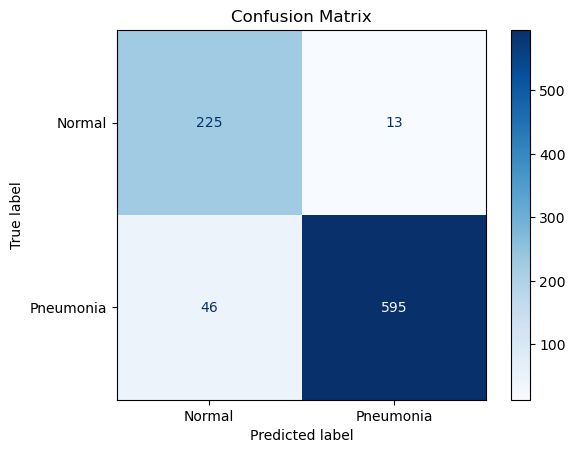

In [21]:
def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

# Plot ROC/AUC Score

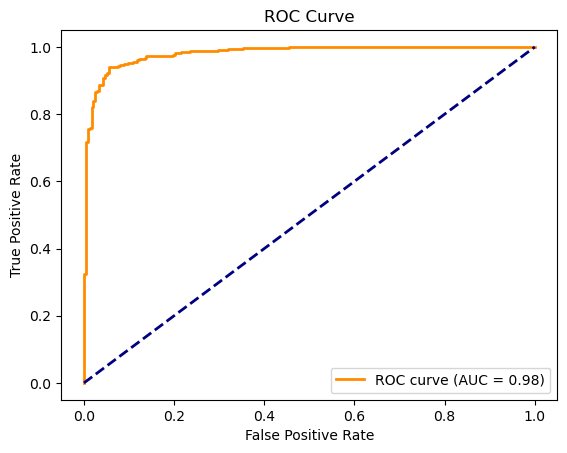

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(model, model.test_loader)

# Plot Gradcam

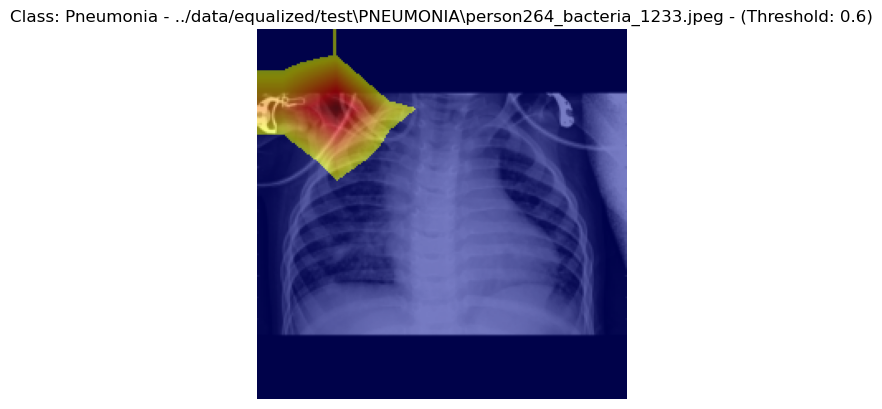

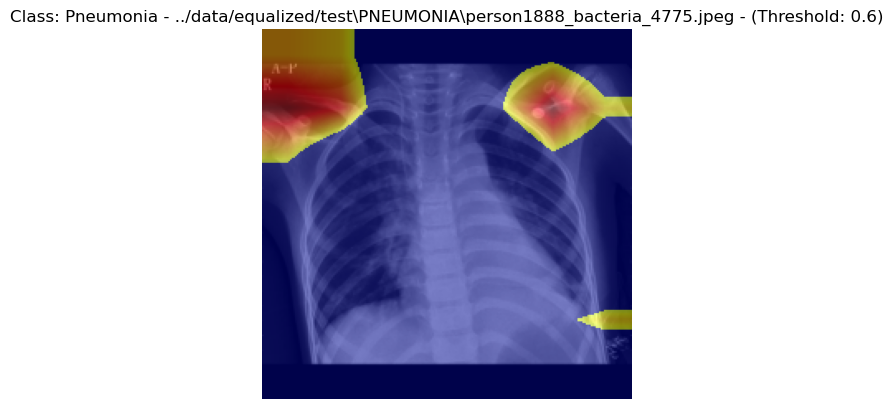

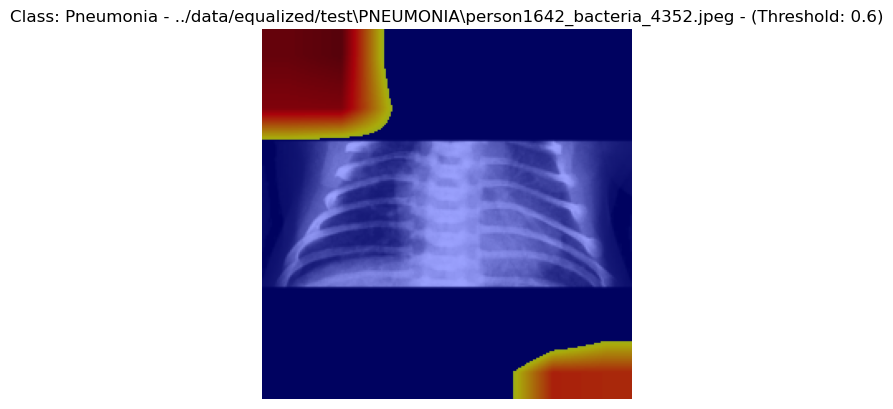

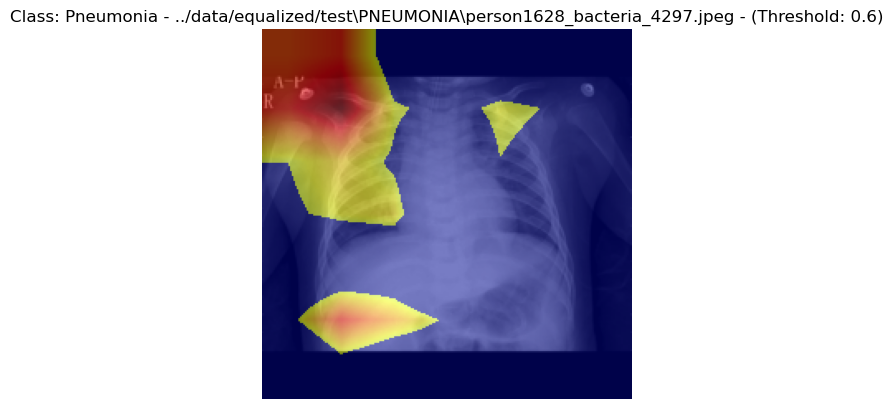

In [23]:
for param in model.feature_extractor.parameters():
    param.requires_grad = True
model.visualize_gradcam(num_samples=4, target_layer=7, class_names=["Normal", "Pneumonia"], threshold=0.6)


# Evaluate Metrics in Tensorboard

In [24]:
# Load TensorBoard extension
%load_ext tensorboard

# Specify the log directory
log_dir = f"tb_logs/{config.model_name}"

# Start TensorBoard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 41512), started 11:33:45 ago. (Use '!kill 41512' to kill it.)

# Classify random images

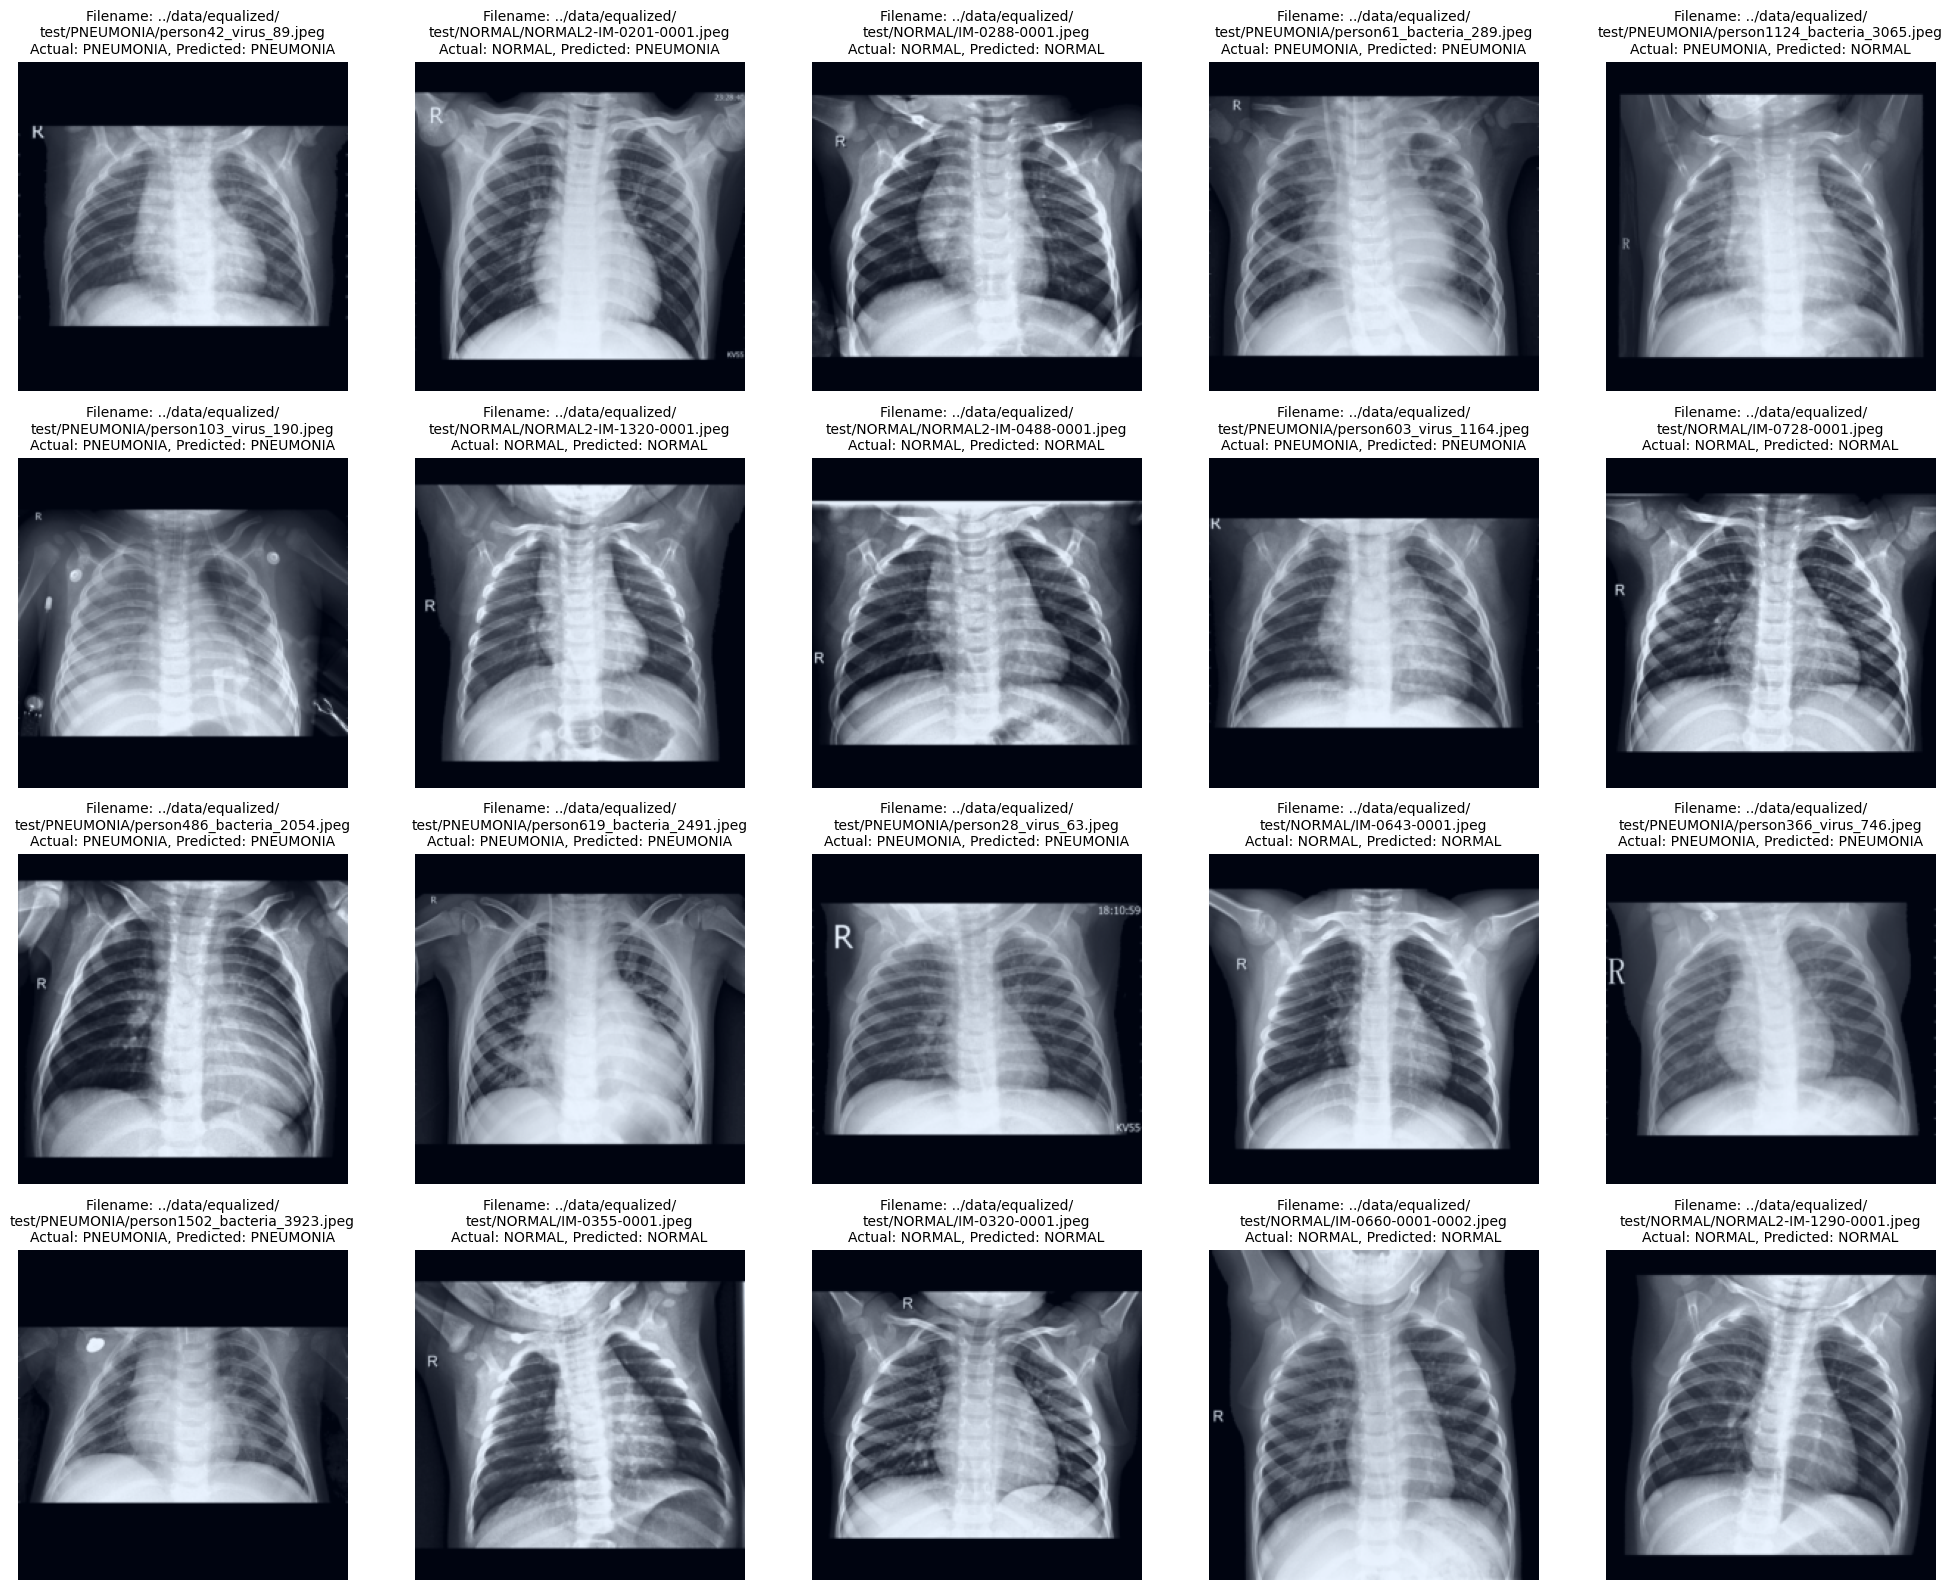

In [25]:
plot_random_images_with_labels(model, model.test_loader, num_images=20)